# 1.Prepare

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda
from keras.models import Model
from keras.models import load_model\
    
import tensorflow as tf
import os
import skimage
from tqdm import *
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16 
from keras.applications.vgg16 import preprocess_input 

/Users/imperatore/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_img_with_fname(fname, size=None):
    """

    :param fname:
    :param size:
    :return:
    """
    img = cv2.imread(fname)
    if size:
        img = cv2.resize(img, size)
    return img

In [3]:
def read_data(flag, path='../../../../assets/brand_images'):
#     train = open(os.path.join(path, 'train.txt'))
#     text = open(os.path.join(path, 'test.txt'))
    content = open(os.path.join(path, '%s.txt' % flag))
    
    imgs = []
    labels = []

    lines = content.readlines()
    for i in tqdm(lines):
        fname, y = i.replace('\n', '').split(' ')
        y = int(y)
#         print(os.path.join(path, 'train', fname))
        x = get_img_with_fname(os.path.join(path, flag, fname), size=(600, 300))
        
        imgs.append(x)
        labels.append(y)
    return np.array(imgs), np.array(labels)

In [4]:
X, y = read_data('train')
X.shape

100%|██████████| 2725/2725 [00:12<00:00, 226.99it/s]


(2725, 300, 600, 3)

In [5]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.1, random_state=0)
trainX.shape, testX.shape

((2452, 300, 600, 3), (273, 300, 600, 3))

---

# 2.数据增强

In [6]:
from keras.callbacks import *
from keras.layers import *
from keras.models import *
from keras.preprocessing import image

datagen = image.ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 0.,
    width_shift_range = 0.,
    height_shift_range = 0.,
    shear_range = 0.,
    zoom_range = 0.,
    channel_shift_range = 0.,
    fill_mode = 'nearest',
    cval = 0.0,
    horizontal_flip = False,
    vertical_flip = False,
    rescale = None,
    preprocessing_function = None,
    data_format = K.image_data_format(),
)

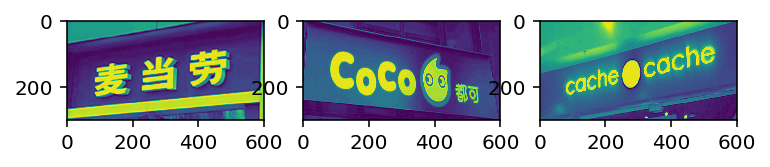

In [7]:
plt.subplot(1, 3, 1)
plt.imshow(testX[0, :, :, 0])
plt.subplot(1, 3, 2)
plt.imshow(testX[1, :, :, 0])
plt.subplot(1, 3, 3)
plt.imshow(testX[2, :, :, 0])

In [8]:
tpx = trainX[0: 3]
tpy = trainy[0: 3]
print(tpy)
tpx.shape
i = 0
XX = None
yy = None
for batch in datagen.flow(trainX, trainy, batch_size=len(trainX)):
    print(batch[0].shape, batch[1].shape)
    print(batch[1])
    if not type(XX) == np.ndarray:
        XX = batch[0]
        yy = batch[1]
    else:
        XX = np.concatenate([XX, batch[0]], axis=0)
        yy = np.concatenate([yy, batch[1]], axis=0)
        
    i += 1
    if i >= 4:
        break
XX.shape

[65 25 73]
(2452, 300, 600, 3) (2452,)
[13 72 83 ... 31 82 25]
(2452, 300, 600, 3) (2452,)
[25 42  3 ... 95 62 85]
(2452, 300, 600, 3) (2452,)
[95 91 69 ... 96 40 95]
(2452, 300, 600, 3) (2452,)
[96 19 53 ... 50 22 11]


(9808, 300, 600, 3)

---

# 3.Model Struct

In [22]:
weight_decay = 0.0005  
nb_epoch=100  
batch_size=32  
width = 600
height = 300

In [23]:
input_tensor = Input((height, width, 3))

In [24]:
vgg = VGG16(weights='../../../../models/VGG16_WEIGHTS.h5', include_top=False, input_tensor=input_tensor)
print(vgg.layers[-1])
# print(' '.join())
print(vgg.output)

Tensor("block5_pool_1/MaxPool:0", shape=(?, 9, 18, 512), dtype=float32)


In [25]:
tensor_shape = vgg.output.shape
print(tensor_shape)

rnn_length = tensor_shape[1].value
rnn_dimen = tensor_shape[2].value * tensor_shape[3].value
units = tensor_shape[3].value

print(rnn_length, rnn_dimen, units)

(?, 9, 18, 512)
9 9216 512


In [39]:
# x = Reshape(input_shape=(vgg.output.shape), target_shape=(rnn_length, rnn_dimen))(vgg.output)
x = Dense(128, kernel_initializer='he_normal')(vgg.output)
x = BatchNormalization()(x)
x = Activation('relu')(x)
print('now x\'s shape:', x.shape)

x = Dropout(0.25)(x)
x = Dense(10, kernel_initializer='he_normal', activation='softmax')(x)
print('now x\'s shape:', x.shape)

now x's shape: (?, 9, 18, 128)
now x's shape: (?, 9, 18, 10)


In [40]:
base_model = Model(input=input_tensor, output=x)

/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [41]:
base_model.compile(loss='mean_squared_error', optimizer='adam')

In [42]:
base_model.fit(XX, yy)

ValueError: Error when checking target: expected dense_15 to have 4 dimensions, but got array with shape (9808, 1)

In [33]:
base_model.layers

In [43]:
XX.shape

(9808, 300, 600, 3)